## Step 1: Set Local Mode

In [1]:
# Global flags for local testing
g_local_run = True
g_measure_mean_std = False  # Skip for faster testing, use ImageNet defaults

print("[OK] Local mode enabled")
print("[INFO] Using ImageNet normalization stats for speed")

[OK] Local mode enabled
[INFO] Using ImageNet normalization stats for speed


## Step 2: Import Libraries

In [2]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall
from torchmetrics import MeanMetric

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image

print("[OK] Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

[OK] Libraries imported successfully
PyTorch version: 2.9.1+cpu
CUDA available: False


## Step 3: Import from src/ (Modular Approach)

In [3]:
# Import configuration classes
from src.config import get_config, TrainingConfiguration, DataConfiguration, SystemConfiguration
from src.utils import calculate_dataset_mean_std, get_imagenet_stats

# Import data modules
from src.dataset import KenyanFood13Dataset
from src.datamodule import KenyanFood13DataModule

# Import model and trainer
from src.model import KenyanFood13Classifier
from src.trainer import train_model

print("[OK] All modules imported from src/")

[OK] All modules imported from src/


## Step 4: Configure for Local Testing

In [4]:
# Use get_config() for local testing with overrides
train_config, data_config, system_config = get_config(
    num_epochs=2,              # Just 2 epochs for quick test
    batch_size=8,              # Small batch for testing
    # learning_rate=0.0001 by default (good for ResNet50)
    use_scheduler=False        # Disable scheduler for quick test
)

# Override for local paths
data_config.annotations_file = "../../data/kenyan-food-13/train_local.csv"
data_config.img_dir = "../../data/kenyan-food-13/images/images"
data_config.num_workers = 0  # Use 0 for Windows compatibility
data_config.batch_size = 8   # Match training config

system_config.output_dir = "./output_local"  # Separate output for local runs

# Optional: Use GoogleNet instead of ResNet50 for faster local testing
# train_config.model_name = "googlenet"

# Optional: Disable early stopping for quick test
# train_config.use_early_stopping = False

print("Configuration Summary:")
print("=" * 50)
print(f"Model: {train_config.model_name}")
print(f"Epochs: {train_config.num_epochs}")
print(f"Batch Size: {train_config.batch_size}")
print(f"Learning Rate: {train_config.learning_rate}")
print(f"Device: {system_config.device}")
print(f"Pre-trained: {train_config.pretrained}")
print(f"Early Stopping: {train_config.use_early_stopping} (patience={train_config.early_stop_patience})")
print(f"Data Path: {data_config.annotations_file}")
print(f"Output: {system_config.output_dir}")
print("=" * 50)

Configuration Summary:
Model: efficientnetv2
Epochs: 2
Batch Size: 8
Learning Rate: 0.0001
Device: cpu
Pre-trained: True
Early Stopping: True (patience=7)
Data Path: ../../data/kenyan-food-13/train_local.csv
Output: ./output_local


## Step 5: Create Data Module

**Note:** Using ImageNet stats for faster startup. For production, calculate actual dataset stats.

In [5]:
# Option 1: Use model-specific preprocessing (RECOMMENDED for pre-trained models)
if not g_measure_mean_std:
    print(f"Using model-specific preprocessing for: {train_config.model_name}")
    data_module = KenyanFood13DataModule(
        data_config=data_config,
        model_name=train_config.model_name
    )
else:
    # Option 2: Calculate from local dataset (slower but more accurate)
    print("Calculating dataset statistics...")
    mean, std = calculate_dataset_mean_std(
        annotations_file=data_config.annotations_file,
        img_dir=data_config.img_dir,
        img_size=(data_config.input_size, data_config.input_size),
        sample_size=100,  # Small sample for local testing
        local_mode=g_local_run
    )
    data_module = KenyanFood13DataModule(data_config=data_config, mean=mean, std=std)

# Setup data module
data_module.setup()

print(f"\n[OK] Data module ready with {data_module.num_classes} classes")

Using model-specific preprocessing for: efficientnetv2
[INFO] Using model-specific input size: 384 (was 224)
[INFO] Using model-specific preprocessing: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
[INFO] Using column 'class' as label column
[INFO] CSV columns: ['id', 'class']
Using 40 samples for training.
Class to index mapping: {'bhaji': 0, 'chapati': 1, 'githeri': 2, 'kachumbari': 3, 'kukuchoma': 4, 'mandazi': 5, 'masalachips': 6, 'matoke': 7, 'nyamachoma': 8, 'pilau': 9, 'sukumawiki': 10, 'ugali': 11}
Dataset initialized with 40 samples belonging to 12 classes.
[INFO] Using column 'class' as label column
[INFO] CSV columns: ['id', 'class']
Using 10 samples for validation.
Class to index mapping: {'bhaji': 0, 'chapati': 1, 'githeri': 2, 'kachumbari': 3, 'kukuchoma': 4, 'mandazi': 5, 'masalachips': 6, 'matoke': 7, 'nyamachoma': 8, 'pilau': 9, 'sukumawiki': 10, 'ugali': 11}
Dataset initialized with 10 samples belonging to 12 classes.

[OK] Data module ready with 12 classes


## Step 6: Inspect Sample Data (Optional)

Batch shape: torch.Size([8, 3, 384, 384])
Labels shape: torch.Size([8])
Sample labels: tensor([ 5,  2,  5, 11, 11])
Image min/max: -2.118 / 2.501


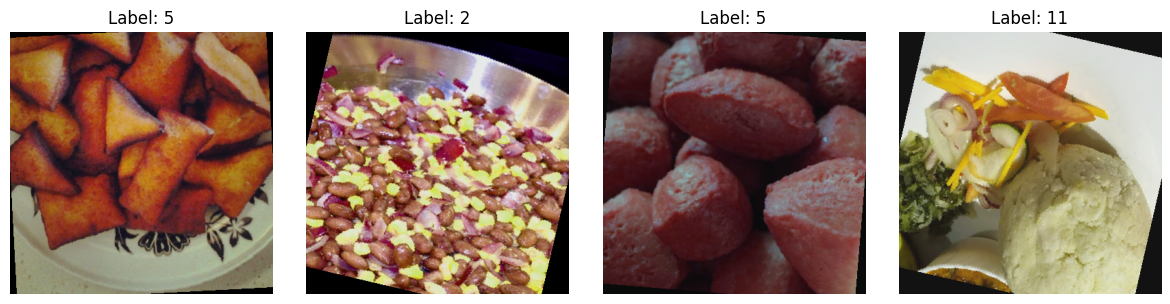

[OK] Data looks good!


In [6]:
# Check a batch of training data
train_loader = data_module.train_dataloader()
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Sample labels: {labels[:5]}")
print(f"Image min/max: {images.min():.3f} / {images.max():.3f}")

# Create reverse mapping: index -> class name
idx_to_class = {v: k for k, v in data_module.train_dataset.class_to_idx.items()}

# Visualize a few samples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i].permute(1, 2, 0).numpy()
    # Denormalize for visualization
    img = img * np.array(data_module.std) + np.array(data_module.mean)
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    label_idx = labels[i].item()
    class_name = idx_to_class[label_idx]
    axes[i].set_title(f"Label: {label_idx} ({class_name})")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print("[OK] Data looks good!")

## Step 7: Create Model

In [ ]:
# Create the model
model = KenyanFood13Classifier(train_config, data_module.num_classes)

print(f"[OK] Model created: {train_config.model_name}")
print(f"Number of classes: {data_module.num_classes}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

## Step 8: Run Quick Training Test

**This will train for just 2 epochs to verify everything works!**

In [ ]:
print("\n" + "="*60)
print("Starting LOCAL TRAINING TEST (2 epochs)")
print("="*60 + "\n")

# Train the model
trained_model, _, checkpoint_callback = train_model(
    training_config=train_config,
    data_config=data_config,
    system_config=system_config,
    model=model,
    data_module=data_module
)

print("\n" + "="*60)
print("LOCAL TRAINING TEST COMPLETE!")
print("="*60)
print(f"Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best validation accuracy: {checkpoint_callback.best_model_score:.4f}")
print("\n[OK] Ready to run on Kaggle with full dataset!")

## Step 9: View TensorBoard Logs (Optional)

In [ ]:
# Load and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir output_local/kenyan_food_logs

## Summary

If you see this, your local test was successful! ✅

**Next Steps:**
1. ✓ Local test passed - code works!
2. Commit changes to Git: `git add . && git commit -m "Ready for Kaggle"`
3. Push to GitHub: `git push origin main`
4. Run on Kaggle using `kaggle_train.ipynb` or clone this repo
5. Train with full dataset and multiple epochs (20-30)
6. Generate predictions and submit to Kaggle competition

**Tips for Kaggle:**
- Increase `num_epochs` to 20-30
- Increase `batch_size` to 64 or 128 (Kaggle has more memory)
- Set `num_workers` to 4
- Enable scheduler: `use_scheduler=True`, `scheduler="cosine"`
- Consider calculating actual dataset mean/std for better results